## Task

In this HW, you will create a conditional variational autoencoder for CIFAR-10 dataset.

In contitional VAEs, you also use the class label as input to both encoder and decoders. And during generation you use the class label as input to decoder to generate an image for that particular class.

Your task is to load the CIFAR10 dataset. Create and train a conditional VAE on that dataset. Finally, as evaluation generate and show 10 pictures for each of the classes.

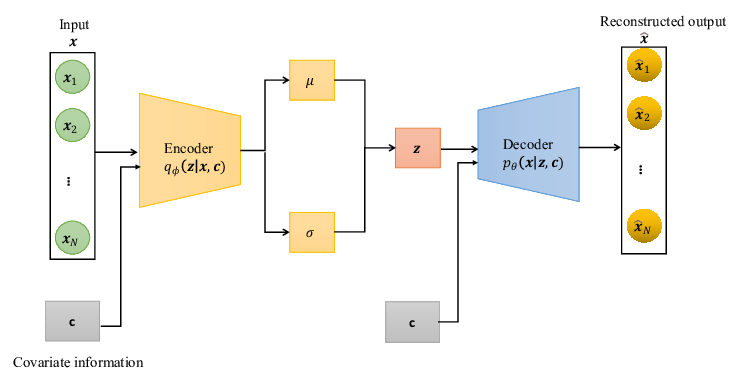

[Image Source](https://www.researchgate.net/figure/Structure-of-the-conditional-variational-autoencoder-CVAE_fig2_365190062)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [3]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [67]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_set = CIFAR10('./data', train=True, transform=transform, download=True)
val_set = CIFAR10('./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [68]:
BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

## Model

In [69]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [70]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block1 = conv_block(in_channels, out_channels)
        self.conv_block2 = conv_block(out_channels, out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.2)


    def forward(self, x, dropout=False):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        if dropout: x = self.dropout(x)
        x = self.maxpool(x)
        return x

In [71]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.trans_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block1 = conv_block(out_channels, out_channels)
        self.conv_block2 = conv_block(out_channels, out_channels)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x, dropout=False):
        x = self.trans_conv(x)
        if dropout: x = self.dropout(x)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return x

In [72]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, num_classes, embedding_dim):
        super().__init__()
        self.enc1 = EncoderBlock(3, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.conv = conv_block(512, 1024)
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(1024 * 2 * 2 + embedding_dim, latent_dim)
        self.fc_logvar = nn.Linear(1024 * 2 * 2 + embedding_dim, latent_dim)
        
    def forward(self, x, y):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        
        x = self.conv(x)
        x = self.flatten(x)
        
        xy = torch.cat((x, y), dim=1)
        mu = self.fc_mu(xy)
        logvar = self.fc_logvar(xy)
        
        return mu, logvar        

In [73]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes, embedding_dim):
        super().__init__()
        
        self.fc = nn.Linear(latent_dim + embedding_dim, 1024 * 2 * 2)
        
        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1, padding=0)
    
    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        x = self.fc(zy)
        x = x.view(-1, 1024, 2, 2)
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.final(x)
        return x

In [74]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [75]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim, num_classes, embedding_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.encoder = Encoder(latent_dim, num_classes, embedding_dim)
        self.decoder = Decoder(latent_dim, num_classes, embedding_dim)

    def forward(self, x, y):
        y = self.embedding(y)
        mu, logvar = self.encoder(x, y)
        z = reparameterize(mu, logvar)
        out = self.decoder(z, y)
        return out, mu, logvar
    
    def generate(self, y):
        y = self.embedding(y)
        z = torch.randn((y.size(0), self.latent_dim)).to(y.device)
        out = self.decoder(z, y)
        return out

## Training

In [134]:
def KLD_Loss(x_out, x, mu, logvar, kl_anneal_factor):
    KLD_WEIGHT = 1e-5
    mse = F.mse_loss(x_out, x, reduction='sum')/1000
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    weighted_kld = KLD_WEIGHT * kl_anneal_factor * kld
    loss = mse + weighted_kld
    return loss, mse, weighted_kld

In [135]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [170]:
# Defining the training function
def train(model, epochs, optimizer, device, scheduler=None, kld_annealing=False):
    # Lists to keep track of the losses for plotting later
    val_losses = []
    train_losses = []
    
    early_stopper = EarlyStopper(patience=3, min_delta=0.3)

    # Iterating over epochs
    for epoch_num in range(epochs):
        model.train() # Sets the model in training mode

        epoch_losses = 0
        mse_losses = 0
        kld_losses = 0
        
        kl_anneal_factor = min(1.0, epoch_num/10) if kld_annealing else 1

        # Looping over batches for each epoch
        for batch_x, batch_y in tqdm(train_loader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_preds, mu, logvar = model(batch_x, batch_y) # Forward pass

            loss, mse, kld = KLD_Loss(batch_y_preds, batch_x, mu, logvar, kl_anneal_factor) # Calculating the loss per batch

            optimizer.zero_grad()
            loss.backward() # Backwards pass
            optimizer.step() # Updating parameters

            epoch_losses += (len(batch_y)*loss.item()) # Keeping track of the losses per batch
            mse_losses += (len(batch_y)*mse.item())
            kld_losses += (len(batch_y)*kld.item())

        epoch_loss = epoch_losses/len(train_loader.dataset)
        mse_loss = mse_losses/len(train_loader.dataset)
        kld_loss = kld_losses/len(train_loader.dataset)
        train_losses.append(epoch_loss) # Keeping training track of the loss per epoch

        model.eval() # Sets the model in evaluation mode for validation
        correctly_labelled = 0
        with torch.no_grad(): # Disables gradient calculation
            val_epoch_losses = 0
            for val_batch_x, val_batch_y in tqdm(val_loader):
                val_batch_x = val_batch_x.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_preds, mu, logvar = model(val_batch_x, val_batch_y) # Predictions
                val_loss, _, _ = KLD_Loss(val_batch_y_preds, val_batch_x, mu, logvar, kl_anneal_factor)
                val_epoch_losses += (len(val_batch_y)*val_loss.item())

            val_epoch_loss = val_epoch_losses/len(val_loader.dataset)
            val_losses.append(val_epoch_loss) # Tracking epoch validation loss

        if scheduler:
            scheduler.step() # Updating the learning rate scheduler if one was provided
            print(f'Epoch: {epoch_num+1}/{epochs}, learning_rate={optimizer.param_groups[0]["lr"]:.6f} train_loss={epoch_loss:.4f}, val_loss={val_epoch_loss:.4f}.')
        else:
            print(f'Epoch: {epoch_num+1}/{epochs}, train_loss={epoch_loss:.4f}, mse_loss={mse_loss:.4f}, kld_loss={kld_loss:.5f}, val_loss={val_epoch_loss:.4f}.')
        print()
        
        if early_stopper.early_stop(val_epoch_loss):
            print('Early Stopping')
            break
            
    print('Training Done')
    return train_losses, val_losses # Returns the losses in order to keep track of them

In [137]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device=torch.device('cpu')
model = AutoEncoder(latent_dim=512, num_classes=10, embedding_dim=32).to(device)
model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

lr=5e-4
weight_decay=1e-2
num_epochs=30

optimizer=optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [138]:
# %%time

# Training the model
train_losses = []
val_losses = []

cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, device, scheduler=None, kl_annealing=True)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

100%|██████████| 157/157 [00:08<00:00, 17.65it/s]


Epoch: 1/30, train_loss=104.4316, mse_loss=104.4316, kld_loss=0.00000, val_loss=89.6212.



100%|██████████| 157/157 [00:08<00:00, 17.95it/s]


Epoch: 2/30, train_loss=75.8445, mse_loss=75.7106, kld_loss=0.13393, val_loss=75.8963.



100%|██████████| 157/157 [00:08<00:00, 17.60it/s]


Epoch: 4/30, train_loss=57.0050, mse_loss=56.8343, kld_loss=0.17077, val_loss=59.9454.



100%|██████████| 157/157 [00:08<00:00, 18.02it/s]


Epoch: 5/30, train_loss=52.5739, mse_loss=52.3818, kld_loss=0.19209, val_loss=50.6065.



100%|██████████| 157/157 [00:08<00:00, 18.19it/s]


Epoch: 6/30, train_loss=49.5923, mse_loss=49.3770, kld_loss=0.21527, val_loss=50.5262.



100%|██████████| 157/157 [00:08<00:00, 18.15it/s]


Epoch: 7/30, train_loss=46.9921, mse_loss=46.7558, kld_loss=0.23623, val_loss=49.4331.



100%|██████████| 157/157 [00:08<00:00, 17.65it/s]


Epoch: 8/30, train_loss=44.8539, mse_loss=44.5925, kld_loss=0.26145, val_loss=45.7620.



100%|██████████| 157/157 [00:08<00:00, 17.72it/s]


Epoch: 9/30, train_loss=43.6348, mse_loss=43.3556, kld_loss=0.27919, val_loss=43.8565.



100%|██████████| 157/157 [00:08<00:00, 18.10it/s]


Epoch: 10/30, train_loss=41.4308, mse_loss=41.1186, kld_loss=0.31219, val_loss=40.9147.



100%|██████████| 157/157 [00:09<00:00, 17.11it/s]


Epoch: 11/30, train_loss=39.7067, mse_loss=39.3654, kld_loss=0.34127, val_loss=40.9919.



100%|██████████| 157/157 [00:08<00:00, 18.05it/s]


Epoch: 12/30, train_loss=38.4194, mse_loss=38.0866, kld_loss=0.33281, val_loss=41.2679.



100%|██████████| 157/157 [00:08<00:00, 18.17it/s]


Epoch: 13/30, train_loss=37.5267, mse_loss=37.2024, kld_loss=0.32430, val_loss=35.2302.



100%|██████████| 157/157 [00:09<00:00, 17.40it/s]


Epoch: 14/30, train_loss=36.1784, mse_loss=35.8474, kld_loss=0.33096, val_loss=34.8184.



100%|██████████| 157/157 [00:08<00:00, 18.05it/s]


Epoch: 15/30, train_loss=35.2315, mse_loss=34.9016, kld_loss=0.32990, val_loss=35.9889.



100%|██████████| 157/157 [00:08<00:00, 17.81it/s]


Epoch: 16/30, train_loss=34.1062, mse_loss=33.7729, kld_loss=0.33325, val_loss=34.2167.



100%|██████████| 157/157 [00:08<00:00, 17.62it/s]


Epoch: 17/30, train_loss=33.3430, mse_loss=33.0089, kld_loss=0.33405, val_loss=34.4278.



100%|██████████| 157/157 [00:08<00:00, 17.48it/s]


Epoch: 18/30, train_loss=32.6705, mse_loss=32.3313, kld_loss=0.33915, val_loss=32.9101.



100%|██████████| 157/157 [00:09<00:00, 17.41it/s]


Epoch: 19/30, train_loss=31.8176, mse_loss=31.4697, kld_loss=0.34799, val_loss=32.7336.



100%|██████████| 157/157 [00:08<00:00, 18.16it/s]


Epoch: 20/30, train_loss=31.0228, mse_loss=30.6705, kld_loss=0.35239, val_loss=33.7344.



100%|██████████| 157/157 [00:08<00:00, 18.07it/s]


Epoch: 21/30, train_loss=30.4897, mse_loss=30.1372, kld_loss=0.35251, val_loss=30.8981.



100%|██████████| 157/157 [00:08<00:00, 17.55it/s]


Epoch: 22/30, train_loss=30.1345, mse_loss=29.7829, kld_loss=0.35159, val_loss=31.1548.



100%|██████████| 157/157 [00:08<00:00, 18.16it/s]


Epoch: 23/30, train_loss=29.6989, mse_loss=29.3513, kld_loss=0.34760, val_loss=30.8161.



100%|██████████| 157/157 [00:08<00:00, 17.74it/s]


Epoch: 24/30, train_loss=29.4364, mse_loss=29.0967, kld_loss=0.33971, val_loss=30.3499.



100%|██████████| 157/157 [00:08<00:00, 18.10it/s]


Epoch: 25/30, train_loss=29.3098, mse_loss=28.9707, kld_loss=0.33903, val_loss=30.6224.



100%|██████████| 157/157 [00:08<00:00, 18.08it/s]


Epoch: 26/30, train_loss=29.0128, mse_loss=28.6731, kld_loss=0.33975, val_loss=29.3116.



100%|██████████| 157/157 [00:08<00:00, 18.18it/s]


Epoch: 27/30, train_loss=28.6484, mse_loss=28.3067, kld_loss=0.34170, val_loss=32.1611.



100%|██████████| 157/157 [00:08<00:00, 17.77it/s]


Epoch: 28/30, train_loss=28.3280, mse_loss=27.9809, kld_loss=0.34718, val_loss=30.2738.



100%|██████████| 157/157 [00:08<00:00, 17.56it/s]


Epoch: 29/30, train_loss=27.8061, mse_loss=27.4535, kld_loss=0.35259, val_loss=28.5612.



100%|██████████| 157/157 [00:08<00:00, 18.15it/s]

Epoch: 30/30, train_loss=27.5959, mse_loss=27.2480, kld_loss=0.34794, val_loss=28.1735.

Training Done


In [172]:
num_epochs = 10

cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, device, scheduler=None, kld_annealing=False)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

100%|██████████| 157/157 [00:08<00:00, 17.58it/s]


Epoch: 1/10, train_loss=27.2028, mse_loss=26.8363, kld_loss=0.36652, val_loss=27.1467.



100%|██████████| 157/157 [00:08<00:00, 18.09it/s]


Epoch: 2/10, train_loss=26.6411, mse_loss=26.2741, kld_loss=0.36703, val_loss=28.1237.



100%|██████████| 157/157 [00:08<00:00, 18.03it/s]


Epoch: 3/10, train_loss=26.4720, mse_loss=26.1084, kld_loss=0.36356, val_loss=26.9284.



100%|██████████| 157/157 [00:08<00:00, 17.50it/s]


Epoch: 4/10, train_loss=26.1831, mse_loss=25.8220, kld_loss=0.36107, val_loss=29.7026.



100%|██████████| 157/157 [00:08<00:00, 17.96it/s]


Epoch: 5/10, train_loss=25.7407, mse_loss=25.3720, kld_loss=0.36874, val_loss=26.0421.



100%|██████████| 157/157 [00:08<00:00, 17.53it/s]


Epoch: 6/10, train_loss=25.5587, mse_loss=25.1910, kld_loss=0.36769, val_loss=26.0135.



100%|██████████| 157/157 [00:08<00:00, 17.96it/s]


Epoch: 7/10, train_loss=25.4366, mse_loss=25.0765, kld_loss=0.36012, val_loss=25.4132.



100%|██████████| 157/157 [00:08<00:00, 17.95it/s]


Epoch: 8/10, train_loss=25.2976, mse_loss=24.9429, kld_loss=0.35469, val_loss=27.6040.



100%|██████████| 157/157 [00:08<00:00, 17.60it/s]


Epoch: 9/10, train_loss=25.2955, mse_loss=24.9446, kld_loss=0.35094, val_loss=27.9190.



100%|██████████| 157/157 [00:08<00:00, 17.87it/s]

Epoch: 10/10, train_loss=25.1049, mse_loss=24.7535, kld_loss=0.35134, val_loss=25.7482.

Early Stopping
Training Done


In [160]:
# num_epochs = 5

# cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, device, scheduler=None)

# train_losses += cycle_train_losses
# val_losses += cycle_val_losses

In [173]:
# Function to plot the training losses and validation losses vs epochs. This will help identify overfitting and model performance
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

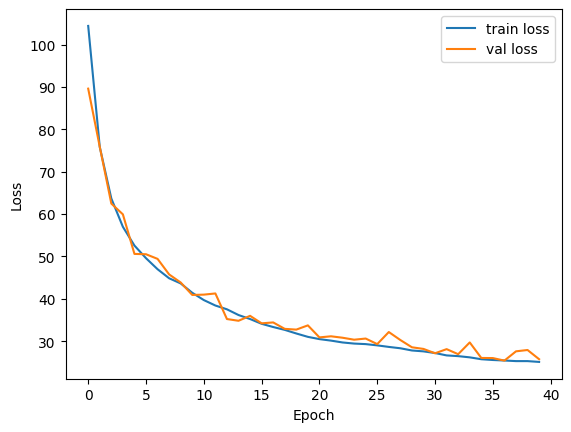

In [174]:
plot_losses(train_losses, val_losses)

## Results

In [175]:
def denormalize(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.247, 0.243, 0.261])
    
    mean = mean[:, None, None]
    std = std[:, None, None]
    return img * std + mean

### Reconstruction

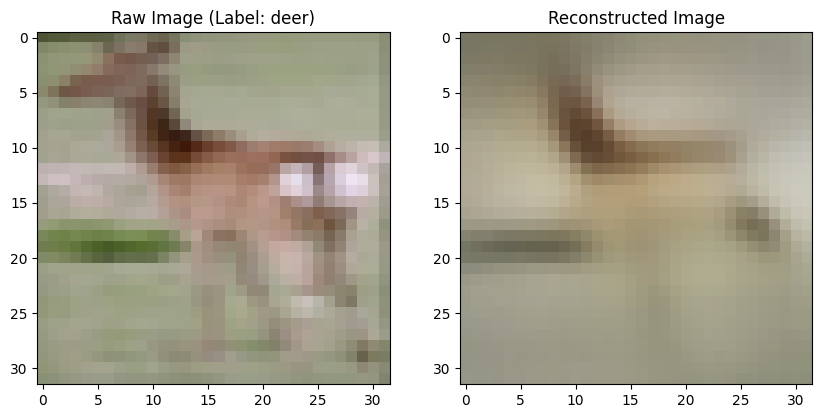

In [176]:
# Testing reconstruction on a train set

classes = ["airplanes", "cars", "birds", "cats", "deer", "dogs", "frogs", "horses", "ships", "trucks"]

i = np.random.randint(0, len(train_set))
x, y = train_set[i]
x = x.unsqueeze(0)
y = torch.tensor([y])

x_o, _, _ = model.module(x.to(device), y.to(device))

plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.title(f'Raw Image (Label: {classes[y.item()]})')
x = denormalize(x.cpu())
plt.imshow(x.squeeze(0).permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
x_o = denormalize(x_o.detach().cpu())
plt.imshow(x_o[0].detach().cpu().permute(1, 2, 0))


### Generation

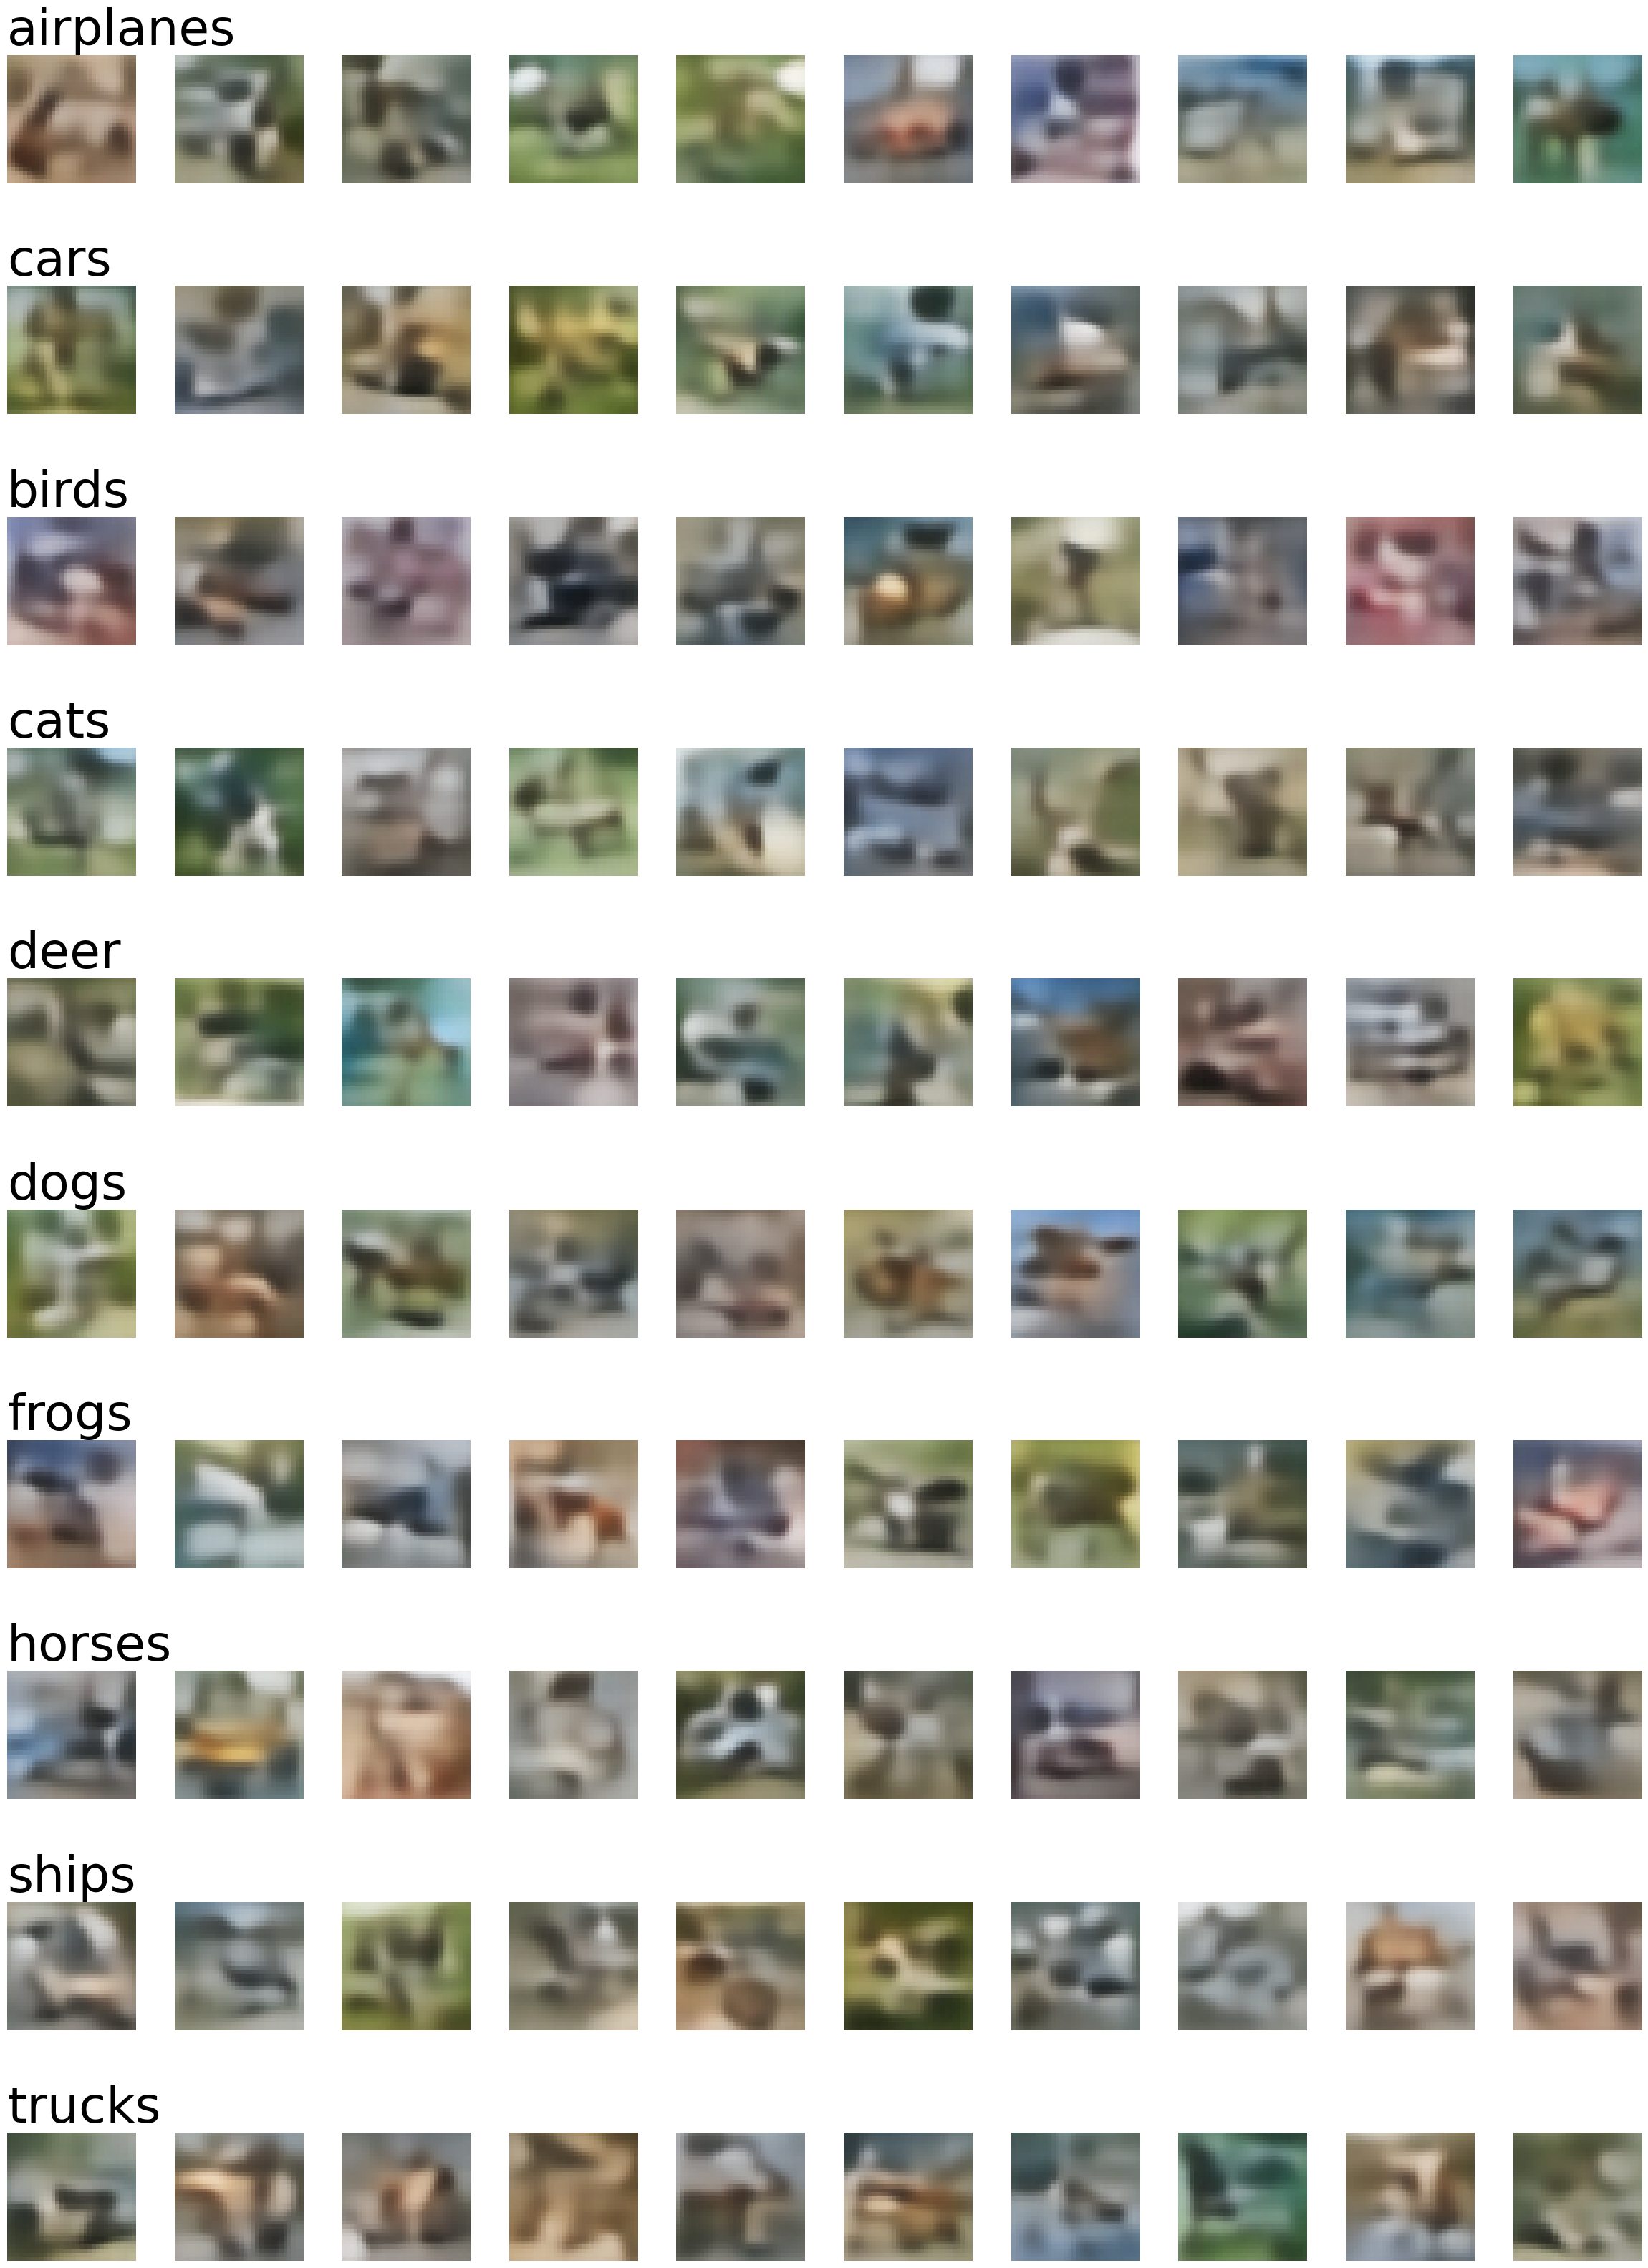

In [177]:
# Testing image generation
plt.figure(figsize=(30, 40))

for label in range(len(classes)):
    for i in range(10):
        plt.subplot(len(classes), 10, label * 10 + i + 1)
        
        img = model.module.generate(torch.tensor([label]).to(device))
        
        plt.imshow(denormalize(img.detach().cpu()[0]).permute(1, 2, 0))
        plt.axis('off')
        
        if i == 0:
            plt.title(classes[label], fontsize=50, loc='left')

plt.subplots_adjust(wspace=0.05, hspace=0.8)
plt.show()